# Testings and benchmarkings for univariate scan functions

We will be using the BXD data for testing purposes. In this notebook, we are testing the univariate scan functionalities, by performing the functions on the 108th BXD trait. 

## Preparation:

In [1]:
pwd()

"/home/zyu20/git/BulkLMM.jl/test/notebooks"

In [2]:
cd("..")

In [3]:
using Test
using Plots
using Tables

In [4]:
include("BXDdata_for_test.jl"); ## Load BXD data used for testing:

In [5]:
include("../src/parallel_helpers.jl");

In [6]:
include("testHelper.jl");

In [7]:
kinship_Gc = readdlm("run-gemma/output/kinship.cXX.txt", '\t');

In [8]:
pheno_y = reshape(pheno[:, 108], :, 1);
(y0, X0, lambda0) = transform_rotation(pheno_y, geno, kinship_Gc); # by default will add an intercept to geno
X0_intercept = reshape(X0[:, 1], :, 1);
X0_covar = X0[:, 2:end];

In [9]:
BLAS.set_num_threads(Threads.nthreads())

## Test simple scans:

In [10]:
@time test_alt = scan(pheno_y, geno, kinship_Gc; reml = false, assumption = "alt", method = "qr");

  3.200954 seconds (5.79 M allocations: 2.600 GiB, 11.31% gc time)


In [11]:
lods_alt = test_alt[4];

In [12]:
findall(lods_alt .< 0) # confirm that uncorrected solution contains invalid LOD scores

241-element Vector{Int64}:
  229
  230
  231
  232
  233
  234
  235
  236
  237
  238
  239
  240
  241
    ⋮
 6112
 6113
 6114
 6115
 6116
 6117
 6118
 6119
 6123
 6124
 7227
 7228

perform correction by taking $(var(y_{108}), 0.1)$

In [13]:
var(pheno_y)

1.6944289276209026

In [14]:
prior = [var(pheno_y), 1/10]

2-element Vector{Float64}:
 1.6944289276209026
 0.1

In [15]:
@time test_alt_corrected = scan(pheno_y, geno, kinship_Gc; prior_a = prior[1], prior_b = prior[2], reml = false, assumption = "alt", method = "qr");

  1.595665 seconds (2.64 M allocations: 1.182 GiB, 11.48% gc time, 0.99% compilation time)


In [16]:
lods_alt_corrected = test_alt_corrected[4];

In [17]:
findall(lods_alt_corrected .< 0)

Int64[]

In [18]:
hcat(lods_alt, lods_alt_corrected)

7321×2 Matrix{Float64}:
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.021912   0.0199922
 0.0567256  0.0417663
 ⋮          
 0.248678   0.263758
 0.248678   0.263758
 0.248678   0.263758
 0.0686881  0.122407
 0.124881   0.136544
 0.124881   0.136544
 0.249213   0.255818
 0.273645   0.288192
 0.271594   0.285219
 0.285893   0.309153
 0.229505   0.219606
 0.229505   0.219606

In [19]:
@benchmark scan(pheno_y, geno, kinship_Gc; reml = false, assumption = "alt", method = "qr")

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.889 s …   2.942 s  ┊ GC (min … max): 6.51% … 7.03%
 Time  (median):     2.915 s              ┊ GC (median):    6.77%
 Time  (mean ± σ):   2.915 s ± 37.571 ms  ┊ GC (mean ± σ):  6.77% ± 0.37%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.89 s         Histogram: frequency by time        2.94 s <

 Memory estimate: 2.60 GiB, allocs estimate: 5792308.

In [20]:
@benchmark scan(pheno_y, geno, kinship_Gc; prior_a = prior[1], prior_b = prior[2], reml = false, assumption = "alt", method = "qr")

BenchmarkTools.Trial: 4 samples with 1 evaluation.
 Range (min … max):  1.381 s …   1.429 s  ┊ GC (min … max): 6.94% … 7.66%
 Time  (median):     1.403 s              ┊ GC (median):    6.84%
 Time  (mean ± σ):   1.404 s ± 20.847 ms  ┊ GC (mean ± σ):  7.00% ± 0.47%

  █               █                   █                   █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.38 s         Histogram: frequency by time        1.43 s <

 Memory estimate: 1.18 GiB, allocs estimate: 2628788.

In [21]:
@benchmark scan(pheno_y, geno, kinship_Gc; prior_a = prior[1], prior_b = prior[2], reml = false, assumption = "alt", method = "cholesky")

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  958.651 ms …   1.015 s  ┊ GC (min … max): 7.31% … 8.54%
 Time  (median):     974.903 ms              ┊ GC (median):    8.02%
 Time  (mean ± σ):   980.672 ms ± 23.232 ms  ┊ GC (mean ± σ):  8.03% ± 0.49%

  █           ▁         ▁                       ▁            ▁  
  █▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  959 ms          Histogram: frequency by time          1.01 s <

 Memory estimate: 933.34 MiB, allocs estimate: 2252108.

In [22]:
@benchmark scan(pheno_y, geno, kinship_Gc; prior_a = prior[1], prior_b = prior[2], reml = false, assumption = "null", method = "cholesky")

BenchmarkTools.Trial: 154 samples with 1 evaluation.
 Range (min … max):  23.939 ms … 63.764 ms  ┊ GC (min … max): 0.00% … 55.22%
 Time  (median):     32.318 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   32.492 ms ±  5.895 ms  ┊ GC (mean ± σ):  7.28% ±  7.91%

   ▁▂  ██        ▄▇▂▂▅▄▁▄▂▂                                    
  ███▃▅██▁▃▃▆██▅▅██████████▆▁▅▃▅█▆█▅▃▆▃▃▁▁▁▁▃▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▃ ▃
  23.9 ms         Histogram: frequency by time        51.3 ms <

 Memory estimate: 33.18 MiB, allocs estimate: 73514.

## Test scan with permutations:

In [23]:
include("../src/scan.jl");

In [24]:
?scan_perms

search: scan_perms scan_perms_distributed base_colorant_type



No documentation found.

`scan_perms` is a `Function`.

```
# 1 method for generic function "scan_perms":
[1] scan_perms(y::Matrix{Float64}, g::Matrix{Float64}, K::Matrix{Float64}; prior_a, prior_b, addIntercept, method, nperms, rndseed, reml, original) in Main at /home/zyu20/git/BulkLMM.jl/src/scan.jl:215
```


In [25]:
try 
    scan_perms(pheno_y, geno, kinship_Gc; nperms = 0, original = false)
catch
    println("Exception caught: when permutations required is missing and the original is dropped.")
end

Exception caught: when permutations required is missing and the original is dropped.


When no permutation is required...

In [26]:
@time test_perms = scan_perms(pheno_y, geno, kinship_Gc; nperms = 0);

  0.078930 seconds (74.07 k allocations: 59.595 MiB, 44.22% gc time)


In [27]:
test_perms

1×7321 Matrix{Float64}:
 0.0219153  0.0219153  0.0219153  0.0219153  …  0.285893  0.229505  0.229505

In [28]:
test_null = scan(pheno_y, geno, kinship_Gc);

In [29]:
maxSqDiff(test_perms, reshape(test_null[3], 1, :))

1.2621774483536189e-27

In [30]:
@time test_perms_1000 = scan_perms(pheno_y, geno, kinship_Gc; method = "cholesky", nperms = 1000, rndseed = 0, reml = false, original = true);

  6.420256 seconds (104.26 k allocations: 17.624 GiB, 8.28% gc time)


Test serial scans on 1000 permuted traits...

In [31]:
BLAS.get_num_threads()

16

In [32]:
@btime scan_perms(pheno_y, geno, kinship_Gc; method = "qr", nperms = 1000, rndseed = 0, reml = false, original = true)

  6.180 s (104373 allocations: 17.62 GiB)


1001×7321 Matrix{Float64}:
 0.0219153    0.0219153    0.0219153    …  0.229505     0.229505
 0.0972076    0.0972076    0.0972076       0.18247      0.18247
 0.263481     0.263481     0.263481        0.00396433   0.00396433
 0.0401656    0.0401656    0.0401656       0.16267      0.16267
 0.00159218   0.00159218   0.00159218      0.0118177    0.0118177
 0.0138914    0.0138914    0.0138914    …  0.14118      0.14118
 0.0755772    0.0755772    0.0755772       0.0746133    0.0746133
 0.00253072   0.00253072   0.00253072      0.359776     0.359776
 0.0273428    0.0273428    0.0273428       0.00503722   0.00503722
 0.0371679    0.0371679    0.0371679       0.250891     0.250891
 0.111992     0.111992     0.111992     …  0.210264     0.210264
 0.000766174  0.000766174  0.000766174     0.0736153    0.0736153
 0.11903      0.11903      0.11903         0.00705106   0.00705106
 ⋮                                      ⋱               ⋮
 0.159683     0.159683     0.159683        0.205708     0.205708

In [33]:
@btime begin
    prior_a = var(pheno_y);
    scan_perms(pheno_y, geno, kinship_Gc; prior_a = prior_a, prior_b = 0.1, method = "qr", nperms = 1000, rndseed = 0, reml = false, original = true);
end

  7.143 s (103872 allocations: 17.62 GiB)


1001×7321 Matrix{Float64}:
 0.0199558   0.0199558   0.0199558   …  0.310909     0.221124    0.221124
 0.0801752   0.0801752   0.0801752      0.155887     0.166119    0.166119
 0.279128    0.279128    0.279128       0.0329295    0.0186396   0.0186396
 0.00686874  0.00686874  0.00686874     5.0648e-5    0.0771077   0.0771077
 0.0266546   0.0266546   0.0266546      0.0037054    0.0118529   0.0118529
 0.00921263  0.00921263  0.00921263  …  0.100416     0.129246    0.129246
 0.0672223   0.0672223   0.0672223      0.238526     0.0689081   0.0689081
 0.0044153   0.0044153   0.0044153      0.158313     0.401842    0.401842
 0.0190463   0.0190463   0.0190463      0.0192315    6.6874e-5   6.6874e-5
 0.0059143   0.0059143   0.0059143      0.0500744    0.208603    0.208603
 0.119681    0.119681    0.119681    …  0.285815     0.338154    0.338154
 0.00438091  0.00438091  0.00438091     0.00996801   0.0601841   0.0601841
 0.20495     0.20495     0.20495        0.00699312   0.00634039  0.00634039
 ⋮ 

In [34]:
@btime begin
    prior_a = var(pheno_y);
    scan_perms(pheno_y, geno, kinship_Gc; prior_a = prior_a, prior_b = 0.1, method = "cholesky", nperms = 1000, rndseed = 0, reml = false, original = true);
end

  5.977 s (103830 allocations: 17.62 GiB)


1001×7321 Matrix{Float64}:
 0.0199558   0.0199558   0.0199558   …  0.310909     0.221124    0.221124
 0.0801752   0.0801752   0.0801752      0.155887     0.166119    0.166119
 0.279128    0.279128    0.279128       0.0329295    0.0186396   0.0186396
 0.00686874  0.00686874  0.00686874     5.0648e-5    0.0771077   0.0771077
 0.0266546   0.0266546   0.0266546      0.0037054    0.0118529   0.0118529
 0.00921263  0.00921263  0.00921263  …  0.100416     0.129246    0.129246
 0.0672223   0.0672223   0.0672223      0.238526     0.0689081   0.0689081
 0.0044153   0.0044153   0.0044153      0.158313     0.401842    0.401842
 0.0190463   0.0190463   0.0190463      0.0192315    6.6874e-5   6.6874e-5
 0.0059143   0.0059143   0.0059143      0.0500744    0.208603    0.208603
 0.119681    0.119681    0.119681    …  0.285815     0.338154    0.338154
 0.00438091  0.00438091  0.00438091     0.00996801   0.0601841   0.0601841
 0.20495     0.20495     0.20495        0.00699312   0.00634039  0.00634039
 ⋮ 

In [35]:
any(test_perms .< 0.0)

false

In [36]:
test_null[1]

3.455401663717786e-8

In [37]:
test_null[2]

0.999999984947842

In [38]:
c_pheno_y = copy(pheno_y);
c_geno = copy(geno);

In [39]:
colStandardize!(c_pheno_y);
colStandardize!(c_geno);

In [40]:
maxSqDiff(reshape(test_null[3], :, 1), reshape(scan(c_pheno_y, c_geno, kinship_Gc)[3], :, 1))

1.2621774483536189e-27

In [41]:
var(c_pheno_y)

1.0000000000000002

In [42]:
hcat(pheno_y, c_pheno_y)

79×2 Matrix{Float64}:
 6.874   0.643286
 5.771  -0.204066
 6.414   0.289903
 7.48    1.10883
 5.064  -0.747201
 5.71   -0.250928
 4.32   -1.31876
 6.845   0.621008
 8.018   1.52214
 6.772   0.564927
 7.372   1.02586
 4.71   -1.01915
 5.802  -0.180251
 ⋮      
 6.47    0.332923
 4.518  -1.16665
 7.542   1.15646
 4.665  -1.05372
 4.341  -1.30263
 6.955   0.705512
 4.338  -1.30493
 6.866   0.63714
 6.088   0.0394615
 6.248   0.162377
 6.727   0.530357
 7.182   0.879899

In [43]:
hcat(geno[:, 1], c_geno[:, 1])

79×2 Matrix{Float64}:
 1.0           0.88622
 1.0           0.88622
 5.18083e-11  -1.1141
 5.18083e-11  -1.1141
 5.18083e-11  -1.1141
 1.0           0.88622
 1.0           0.88622
 5.18083e-11  -1.1141
 1.0           0.88622
 1.0           0.88622
 5.18083e-11  -1.1141
 5.18083e-11  -1.1141
 1.0           0.88622
 ⋮            
 5.18083e-11  -1.1141
 5.18083e-11  -1.1141
 1.0           0.88622
 1.0           0.88622
 1.0           0.88622
 1.0           0.88622
 5.18083e-11  -1.1141
 1.0           0.88622
 1.0           0.88622
 1.0           0.88622
 1.0           0.88622
 1.0           0.88622

In [44]:
c_pheno = copy(pheno);

In [45]:
@time colStandardize!(c_pheno)

  0.036831 seconds (22 allocations: 834.797 KiB)


## Exploring the batching idea:

In [46]:
function get_hsqs_from_null(Y::Array{Float64, 2}, K::Array{Float64, 2}; reml::Bool = false)

    (n, m) = size(Y);
    intercept = ones(n, 1);
    (Y0, intercept0, lambda0) = transform_rotation(Y, intercept, K; addIntercept = false);
    
    hsqs_from_null = Array{Float64, 1}(undef, m);
    
    prior = zeros(2);
    prior[2] = 1/100;
    
    for i in 1:m
        
        y0_i = reshape(Y0[:, i], :, 1);
        prior[1] = var(y0_i);
        
        out00 = fitlmm(y0_i, intercept0, lambda0, prior; reml = reml, method = "cholesky");
        hsqs_from_null[i] = out00.h2;
        
    end
    
    return hsqs_from_null;
    
end

get_hsqs_from_null (generic function with 1 method)

In [47]:
@time begin
    
    hsqs_from_null = get_hsqs_from_null(pheno, kinship_Gc; reml = false);
        
end

 15.390233 seconds (39.88 M allocations: 14.568 GiB, 11.54% gc time)


35556-element Vector{Float64}:
 5.252307989014744e-16
 2.7523998467152616e-15
 8.4984128456085e-16
 8.97201316153285e-16
 6.149509305168035e-15
 6.149509305168035e-15
 1.6545276960836124e-14
 1.9792698497492543e-14
 6.149509305168035e-15
 2.224913368023175e-15
 3.418985067508508e-14
 2.5112087832701304e-15
 6.149509305168035e-15
 ⋮
 2.224913368023175e-15
 3.800605764727595e-15
 0.16416386001268723
 0.07248978785583318
 3.0747546525840177e-15
 1.4445541114835797e-14
 6.149509305168035e-15
 3.5040026756150213e-15
 8.049812187531831e-15
 0.06079799884267384
 2.224913368023175e-15
 2.34890354044044e-15

In [48]:
function get_hsqs_from_null_not_correct(Y::Array{Float64, 2}, K::Array{Float64, 2}; reml::Bool = false)

    (n, m) = size(Y);
    intercept = ones(n, 1);
    (Y0, intercept0, lambda0) = transform_rotation(Y, intercept, K; addIntercept = false);
    
    hsqs_from_null = Array{Float64, 1}(undef, m);
    prior = zeros(2);
    
    for i in 1:m
        
        y0_i = reshape(Y0[:, i], :, 1);
        
        out00 = fitlmm(y0_i, intercept0, lambda0, prior; reml = reml, method = "cholesky");
        hsqs_from_null[i] = out00.h2;
        
    end
    
    return hsqs_from_null;
    
end

get_hsqs_from_null_not_correct (generic function with 1 method)

In [49]:
@time begin
    
    hsqs_from_null_nc = get_hsqs_from_null_not_correct(pheno, kinship_Gc; reml = false);
        
end

  9.752861 seconds (25.07 M allocations: 9.152 GiB, 11.61% gc time)


35556-element Vector{Float64}:
 6.149509305168035e-15
 0.03652893984751002
 3.0747546525840177e-15
 4.8127522921181266e-15
 6.025519132750762e-15
 1.2227082149781879e-14
 0.13051026756804227
 0.1741043748205249
 8.927378517499368e-14
 4.6504470492884445e-15
 0.09142169756832183
 6.149509305168035e-15
 3.599985451485494e-15
 ⋮
 4.188674842057219e-14
 2.107468191001147e-14
 0.7218209220376574
 0.12763693618531463
 2.107468191001147e-14
 0.4181039505903898
 0.19611050361840837
 0.08632254837241103
 0.1092762621170319
 0.6094587800596163
 3.255168280817777e-13
 3.599985451485494e-15

In [50]:
@benchmark get_hsqs_from_null(pheno, kinship_Gc; reml = false)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 15.003 s (11.17% GC) to evaluate,
 with a memory estimate of 14.57 GiB, over 39875315 allocations.

In [51]:
@benchmark get_hsqs_from_null_not_correct(pheno, kinship_Gc; reml = false)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 9.377 s (11.21% GC) to evaluate,
 with a memory estimate of 9.15 GiB, over 25072439 allocations.

In [52]:
maximum(hsqs_from_null)

0.9511199328788418

In [53]:
maximum(hsqs_from_null_nc)

0.999999984947842

In [54]:
function get_hsqs_from_null_std(Y::Array{Float64, 2}, K::Array{Float64, 2}; reml::Bool = false)

    (n, m) = size(Y);
    intercept = ones(n, 1);
    
    colStandardize!(Y);
    
    (Y0, intercept0, lambda0) = transform_rotation(Y, intercept, K; addIntercept = false);
    
    hsqs_from_null = Array{Float64, 1}(undef, m);
    prior = [1.0, 0.1];
    
    for i in 1:m
        
        y0_i = reshape(Y0[:, i], :, 1);
        out00 = fitlmm(y0_i, intercept0, lambda0, prior; reml = reml, method = "cholesky");
        hsqs_from_null[i] = out00.h2;
        
    end
    
    return hsqs_from_null;
    
end

get_hsqs_from_null_std (generic function with 1 method)

In [55]:
c_pheno = copy(pheno);
c_pheno[:, 108]

79-element Vector{Float64}:
 6.874
 5.771
 6.414
 7.48
 5.064
 5.71
 4.32
 6.845
 8.018
 6.772
 7.372
 4.71
 5.802
 ⋮
 6.47
 4.518
 7.542
 4.665
 4.341
 6.955
 4.338
 6.866
 6.088
 6.248
 6.727
 7.182

In [56]:
Threads.nthreads()

16

In [57]:
# BLAS.set_num_threads(Threads.nthreads())

In [66]:
BLAS.set_num_threads(1)

In [64]:
@benchmark get_hsqs_from_null_std(c_pheno, kinship_Gc; reml = false)

LoadError: InterruptException:

In [67]:
@time hsqs_from_null_std = get_hsqs_from_null_std(c_pheno, kinship_Gc; reml = false);

  9.747043 seconds (24.83 M allocations: 9.064 GiB, 11.40% gc time)


In [60]:
histogram(hsqs_from_null)

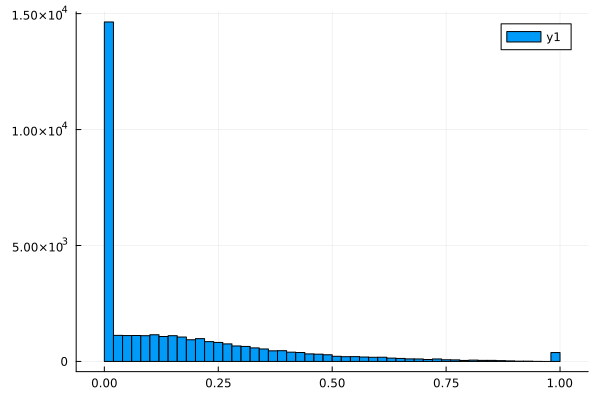

In [61]:
histogram(hsqs_from_null_nc)

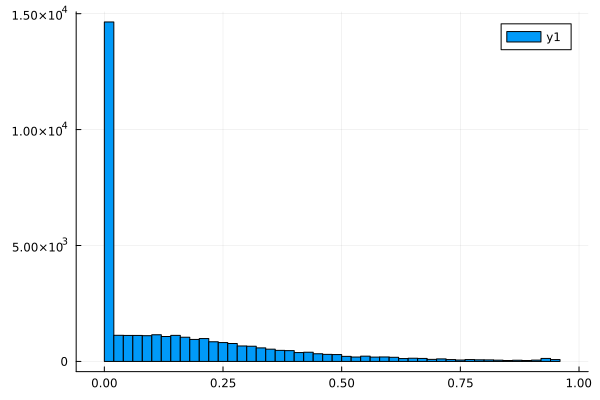

In [62]:
histogram(hsqs_from_null_std)